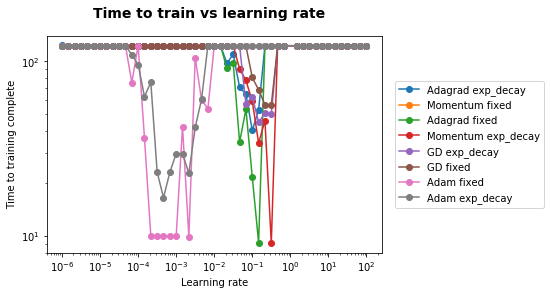

Momentum fixed Learning rate 0.0006812920690579616, Time to training complete 122.6894633769989
Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [ ]:
#   Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.
"""Convolutional Neural Network Estimator for MNIST, built with tf.layers."""


from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
from datetime import datetime
import traceback
import uuid
import shutil
import os

from matplotlib import pyplot as plt
from IPython.display import clear_output
import csv

import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.training import session_run_hook
from tensorflow.python.training.basic_session_run_hooks import _as_graph_element

try:
  from google.colab import auth
  from googleapiclient.discovery import build
  from googleapiclient.http import MediaFileUpload
except:
  pass
    

class EarlyStopping(session_run_hook.SessionRunHook):

  def __init__(self, model, target=0.99, check_every=100, max_mins=10):
    self.model = model # yuck
    self.target = target
    self.counter = 0
    self.check_every = check_every
    self.max_mins = max_mins

  def after_create_session(self, session, coord):
    self.start_time = time.time()
        
  def before_run(self, run_context):
    self.counter += 1
    self.should_check = (self.counter % self.check_every) == 0

    if self.should_check:
      try:
          return session_run_hook.SessionRunArgs(self.model.accuracy)
      except:
          pass

  def after_run(self, run_context, run_values):
    if self.should_check:
      acc = run_values.results
      if acc[1] > self.target:
        tf.logging.info("Early stopping")
        run_context.request_stop()
        
    if time.time() - self.start_time > 60*self.max_mins:
      run_context.request_stop()

      
class Ploty(object):

  def __init__(self, output_path='/output/', title='', x='', y="Time to training complete", log_y=False, log_x=False,clear_screen=True):
    self.output_path = output_path
    self.title = title
    self.label_x = x
    self.label_y = y
    self.log_y = log_y
    self.log_x = log_x
    self.clear_screen = clear_screen
    
    self.x = []
    self.y = []
    self.c = []
    self.datas = {}
    
    self.c_i = 0
    self.cmap = plt.cm.get_cmap('hsv', 10)
    
    
  def ensure(self, name):
    if name not in self.datas:
      self.datas[name] = {
        "c": self.cmap(self.c_i),
        "x": [],
        "y": []
      }
      self.c_i += 1

  def add_result(self, y, x, name):
    self.ensure(name)
    
    self.datas[name]["x"].append(x)
    self.datas[name]["y"].append(y)
   
    self.render()
    self.save_csv()
    
    print("{} {} {}, {} {}".format(name, self.label_x, x, self.label_y, y))
    
  def runningMeanFast(x, N):
    return np.convolve(np.array(x), np.ones((N,))/N)[(N-1):]
  
  def render(self):
    self.render_pre()
    
    for k, d in self.datas.items():
      plt.plot(d['x'], d['y'], '-o', label=k)
      
    self.render_post()
      
      
  def render_pre(self):
    if self.clear_screen:
      clear_output()
    
    self.fig = plt.figure()
    self.ax = self.fig.add_subplot(111)
    self.fig.suptitle(self.title, fontsize=14, fontweight='bold')
    
    if self.log_x:
      self.ax.set_xscale('log')
    
    if self.log_y:
      self.ax.set_yscale('log')
      
    self.ax.set_xlabel(self.label_x)
    self.ax.set_ylabel(self.label_y)
    
  def render_post(self):
    img_name = self.output_path + self.title.replace(" ", "_") + '.png'
    lgd = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
    
    try:
        os.remove(img_name)
    except:
        pass
        
    plt.savefig(img_name, bbox_extra_artists=(lgd,), bbox_inches='tight')
    tf.logging.info("Saved image: " + img_name)
    plt.show()
    
  def save_csv(self):
    try:
        os.remove(csv_name)
    except:
        pass
    
    csv_name = self.output_path + self.title.replace(" ", "_") + '.csv'
    
    with open(csv_name, 'w') as csvfile:
      writer = csv.writer(csvfile)
      
      for k, d in self.datas.items():
        for i in zip(d['x'], d['y']):
          writer.writerow([i[0], i[1], k])
      tf.logging.info("Saved CSV: " + csv_name)
    
  
  def copy_to_drive(self, snapshot=False):   
    auth.authenticate_user()
    drive_service = build('drive', 'v3')
    
    if snapshot:
      name = self.title + "_latest"
    else:
      name = self.title +'_' + str(datetime.now())
      
    def do_copy(source_name, dest_name, mime):
      file_metadata = {
        'name': dest_name,
        'mimeType': mime
      }
      media = MediaFileUpload(self.output_path + source_name, 
                              mimetype=file_metadata['mimeType'],
                              resumable=True)
      
      created = drive_service.files().create(body=file_metadata,
                                             media_body=media,
                                             fields='id').execute()
      
    do_copy(self.title+'.csv', name + '.csv', 'text/csv')
    do_copy(self.title+'.png', name + '.png', 'image/png')
    
    
    

class Model(object):

    def __init__(self, optimizer_fn, val_target=0.99, max_mins=100, scale=1, output_path="/tmp/"):
        self.optimizer_fn = optimizer_fn
        self.val_target = val_target
        self.max_mins = max_mins
        self.scale = scale
        self.output_path = output_path

    def cnn_model_fn(self, features, labels, mode):
        """Model function for CNN."""
        tf.set_random_seed(3141592)
        
        # Input Layer
        # Reshape X to 4-D tensor: [batch_size, width, height, channels]
        # MNIST images are 28x28 pixels, and have one color channel
        input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

        # Convolutional Layer #1
        # Computes 32 features using a 5x5 filter with ReLU activation.
        # Padding is added to preserve width and height.
        # Input Tensor Shape: [batch_size, 28, 28, 1]
        # Output Tensor Shape: [batch_size, 28, 28, 32]
        conv1 = tf.layers.conv2d(
            inputs=input_layer,
            filters=round(32*self.scale),
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)

        # Pooling Layer #1
        # First max pooling layer with a 2x2 filter and stride of 2
        # Input Tensor Shape: [batch_size, 28, 28, 32]
        # Output Tensor Shape: [batch_size, 14, 14, 32]
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

        # Convolutional Layer #2
        # Computes 64 features using a 5x5 filter.
        # Padding is added to preserve width and height.
        # Input Tensor Shape: [batch_size, 14, 14, 32]
        # Output Tensor Shape: [batch_size, 14, 14, 64]
        conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=round(64 * self.scale),
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)

        # Pooling Layer #2
        # Second max pooling layer with a 2x2 filter and stride of 2
        # Input Tensor Shape: [batch_size, 14, 14, 64]
        # Output Tensor Shape: [batch_size, 7, 7, 64]
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

        # Flatten tensor into a batch of vectors
        # Input Tensor Shape: [batch_size, 7, 7, 64]
        # Output Tensor Shape: [batch_size, 7 * 7 * 64]
        pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * round(self.scale* 64)])

        # Dense Layer
        # Densely connected layer with 1024 neurons
        # Input Tensor Shape: [batch_size, 7 * 7 * 64]
        # Output Tensor Shape: [batch_size, 1024]
        dense = tf.layers.dense(inputs=pool2_flat, units=round(1024*self.scale), activation=tf.nn.relu)

        # Add dropout operation; 0.6 probability that element will be kept
        dropout = tf.layers.dropout(
            inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

        # Logits layer
        # Input Tensor Shape: [batch_size, 1024]
        # Output Tensor Shape: [batch_size, 10]
        logits = tf.layers.dense(inputs=dropout, units=10)

        predictions = {
            # Generate predictions (for PREDICT and EVAL mode)
            "classes": tf.argmax(input=logits, axis=1),
            # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
            # `logging_hook`.
            "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }

        # Add evaluation metrics (for EVAL mode)
        eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(
                labels=labels, predictions=predictions["classes"])}

        # Ugly bad state leak, to fix later. Blame tensorflow
        self.accuracy = eval_metric_ops["accuracy"]


        if mode == tf.estimator.ModeKeys.PREDICT:
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

        # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

        # Configure the Training Op (for TRAIN mode)
        if mode == tf.estimator.ModeKeys.TRAIN:
          global_step = tf.train.get_global_step()
          self.optimizer = self.optimizer_fn(global_step)

          train_op = self.optimizer.minimize(
              loss=loss,
              global_step=global_step)
          return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


    def measure(self, unused_argv=[]):
        
        model_dir = self.output_path + str(uuid.uuid1())
        
        # Load training and eval data
        mnist = tf.contrib.learn.datasets.load_dataset("mnist")
        train_data = mnist.train.images # Returns np.array
        train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
        eval_data = mnist.test.images   # Returns np.array
        eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
        
        time_start = time.time()
        
        model_fn = lambda features, labels, mode: self.cnn_model_fn(
            features, labels, mode)

        # Create the Estimator
        mnist_classifier = tf.estimator.Estimator(
            model_fn=model_fn, model_dir=model_dir)

        # Set up logging for predictions
        # Log the values in the "Softmax" tensor with label "probabilities"
        tensors_to_log = {"probabilities": "softmax_tensor"}
        logging_hook = tf.train.LoggingTensorHook(
            tensors=tensors_to_log, every_n_iter=50)

        early_stop = EarlyStopping(self, target=self.val_target, max_mins=self.max_mins)

        # Train the model
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"x": train_data},
            y=train_labels,
            batch_size=100,
            num_epochs=None,
            shuffle=True)

        mnist_classifier.train(
            input_fn=train_input_fn,
            steps=200000,
            hooks=[early_stop])

        # Evaluate the model and print results
        eval_input_fn = tf.estimator.inputs.numpy_input_fn(
            x={"x": eval_data},
            y=eval_labels,
            num_epochs=1,
            shuffle=False)
        eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
        
        time_end = time.time()
        time_taken = time_end - time_start
        
        eval_results["time_taken"] = time_taken
        
        shutil.rmtree(model_dir)
        
        return eval_results
      
      
def LRRange(mul=5):
  
  for i in range(mul*6, 0, -1):
    lr = pow(0.1, i/mul)
    yield lr
     

  for i in range(1, 2*mul+1):
    lr = pow(10, i/mul)
    yield lr
    
    
def lr_schedule(optimizer, starter_learning_rate=0.1, 
                global_step=None, mode="fixed", 
                decay_rate=0.96, decay_steps=1000, 
                cycle_lr_decay=0.001, cycle_length=2000):
  
  if mode == "fixed":
    return optimizer(starter_learning_rate)
  
  elif mode == "exp_decay":
    lr = tf.train.exponential_decay(starter_learning_rate, global_step,
                                    decay_steps, decay_rate, staircase=True)
    return optimizer(lr)
  
  elif mode == "cosine_restart":
    lr = tf.train.cosine_decay_restarts(
      starter_learning_rate,
      global_step,
      cycle_length,
      alpha=cycle_lr_decay)
    
    return optimizer(lr)
  
  elif mode == "triangle":
  
    min_lr = starter_learning_rate * cycle_lr_decay
  
    cycle = tf.floor(1+global_step/(2*cycle_length))
    x = tf.abs(global_step/cycle_length - 2*cycle + 1)
    lr = starter_learning_rate + (starter_learning_rate-min_lr)*tf.maximum(0, (1-x))/float(2**(cycle-1))
    
    


tf.logging.set_verbosity(tf.logging.WARN)
output_path = "/output/"


optimizers = {
    "Adam": tf.train.AdamOptimizer,
    "Adagrad": tf.train.AdagradOptimizer,
    "Momentum": lambda lr: tf.train.MomentumOptimizer(lr, 0.5),
    "GD": tf.train.GradientDescentOptimizer,
    "Adadelta": tf.train.AdadeltaOptimizer,
    "RMSProp": tf.train.RMSPropOptimizer,  
}

ideal_lr = {
  "Adam": 0.001,
  "Adagrad": 0.5,
  "Momentum": 10,
  "GD": 0.5,
  "Adadelta": 10,
  "RMSProp": 0.005,  
}

schedules = [
  "exp_decay", 
  "fixed", 
#       "cosine_restart"
]


def run(optimizer="Adam", schedule="fixed", lr=0.01, scale=1, max_mins=2):

    opt = optimizers[optimizer]

    def get_optimizer(global_step):
        return lr_schedule(opt, lr, global_step=global_step, mode=schedule)

    m = Model(optimizer_fn=get_optimizer, val_target=0.97, max_mins=max_mins, scale=scale)

    return m.measure()


def plt_time_to_train():
    p = Ploty(output_path=output_path, title="Time to train vs learning rate", x="Learning rate",log_x=True, log_y=True)
    for opt in optimizers.keys():
      for sched in schedules:
        for lr in LRRange(6):
          try:
            r = run(opt, sched, lr, scale=3)
            p.add_result(r["time_taken"], lr, opt + " " + sched )

          except Exception as e:
            tf.logging.error(e)
            pass

      try:
        p.copy_to_drive()  
      except Exception as e:
        tf.logging.error(e)
        pass

def plt_time_vs_model_size(oversample = 4):
    
    p = Ploty(output_path=output_path,title="Time to train vs size of model",x="Model scale",clear_screen=True)
    for opt in optimizers.keys():
        for sched in schedules:
            for i in range(1*oversample, 10*oversample):
              scale = i/oversample
              try:
                r = run(opt, sched, ideal_lr[opt], scale=scale, max_mins=4)
                print(r, opt, sched, scale)
                if r["accuracy"] >= 0.96:
                  p.add_result(r["time_taken"], scale, opt + " " + sched)
                else:
                  tf.logging.error("Failed to train.")

              except Exception as e:
                tf.logging.error(e)
                traceback.print_stack()
                pass


print("starting...")

# plt_time_vs_model_size()
plt_time_to_train()

